# Question 5: Use the available variables to construct a model that predicts delays.

### Read Neccesary Libraries


In [1]:

import pandas as pd
from datetime import datetime
import sqlite3 as sqlite3
import pyarrow as pa
import pyarrow.csv as pcsv
import matplotlib.pyplot as plt


#importing the packages that will be used for q5 machine learning 
#machine learning
from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.datasets import fetch_openml
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

In [2]:

# Read the data
d1 = pcsv.read_csv("D:/R files/2004.csv").to_pandas()
d2 = pcsv.read_csv("D:/R files/2005.csv").to_pandas()
d3 = pcsv.read_csv("D:/R files/2006.csv").to_pandas()
plane_data = pd.read_csv("D:/R files/plane-data.csv")
airports = pcsv.read_csv("D:/R files/airports.csv").to_pandas()

conn = sqlite3.connect("Coursework_1234.db")
c = conn.cursor()

# Remove table if it exists
c.execute('''DROP TABLE IF EXISTS d36''')
# Remove table if it exists
c.execute('''DROP TABLE IF EXISTS airports''')

# Remove table if it exists
c.execute('''DROP TABLE IF EXISTS plane_data''')

#use .to_sql to create the tables and data from jupyter to SQL
airports.to_sql('airports', con = conn, index = False)
plane_data.to_sql('plane_data',con=conn,index=False)
d1.to_sql('d36', conn, if_exists='append', index=False)
d2.to_sql('d36', conn, if_exists='append', index=False)
d3.to_sql('d36', conn, if_exists='append', index=False)


7141922

In [3]:
#querying the data
query = c.execute('''
SELECT d.ArrDelay,d.CRSDepTime,d.CRSArrTime,d.DepDelay,d.TaxiIn,d.TaxiOut,d.Distance,d.ActualElapsedTime,d.Origin,d.Dest,
d.TailNum,a1.lat as lat_x,a1.long as long_x,a2.lat as lat_y, a2.long as long_y
FROM d36 d 
Inner Join airports a1 on d.Origin=a1.iata
Inner join airports a2 on d.Dest=a2.iata
WHERE Diverted = 0 AND Cancelled = 0 AND DepDelay IS NOT NULL AND ArrDelay IS NOT NULL
LIMIT 110000
''').fetchall()

In [5]:
#Convert to dataframe
df = pd.DataFrame(query,columns=['ArrDelay','CRSDepTime','CRSArrTime','DepDelay',
                                   'TaxiIn','TaxiOut','Distance','ActualElapsedTime','Origin','Dest','TailNum','Lat_x','Long_x',
                                'Lat_y','Long_y'])

In [6]:
# Create Target Variable based on ArrDelay

# create a new column based on conditions
df['delayed'] = np.where((df['ArrDelay'] <= 0), 0, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ArrDelay           110000 non-null  float64
 1   CRSDepTime         110000 non-null  int64  
 2   CRSArrTime         110000 non-null  int64  
 3   DepDelay           110000 non-null  float64
 4   TaxiIn             110000 non-null  int64  
 5   TaxiOut            110000 non-null  int64  
 6   Distance           110000 non-null  int64  
 7   ActualElapsedTime  110000 non-null  float64
 8   Origin             110000 non-null  object 
 9   Dest               110000 non-null  object 
 10  TailNum            110000 non-null  object 
 11  Lat_x              110000 non-null  float64
 12  Long_x             110000 non-null  float64
 13  Lat_y              110000 non-null  float64
 14  Long_y             110000 non-null  float64
 15  delayed            110000 non-null  int32  
dtypes:

In [8]:
numerical_features = ['CRSArrTime','CRSDepTime','Lat_x','Long_x','Lat_y','Long_y','TaxiIn','TaxiOut','Distance','ActualElapsedTime']
categorical_features=['Origin','Dest']


In [9]:
#Scale Numerical Features

data=df[numerical_features]
object1= StandardScaler()
# standardization 
scale = object1.fit_transform(data) 


In [10]:
# Encode Nominal Features  
nominal_features = pd.get_dummies(df[categorical_features], drop_first=True)

In [11]:
#Convert to dataframe
df1 = pd.DataFrame(scale,columns=numerical_features)

In [12]:
target=pd.DataFrame(df['delayed'],columns=['delayed'])

In [13]:
target

,delayed
0,0
1,0
2,1
3,0
4,1
...,...
109995,0
109996,1
109997,0
109998,0


In [14]:
# concatenate numerical and categorical features
df2 = np.concatenate([df1, nominal_features], axis=1)
#df2= np.concatenate([df2, target], axis=1)

In [15]:
# concatenate numerical and categorical features
combined_array = np.concatenate([df1, nominal_features], axis=1)

# create a new dataframe from the concatenated array
column_names = list(df1.columns) + list(nominal_features.columns)
df2 = pd.DataFrame(combined_array, columns=column_names)

In [16]:
# concatenate numerical and categorical features
combined_array = np.concatenate([df2, target], axis=1)

# create a new dataframe from the concatenated array
column_names = list(df2.columns) + list(target.columns)
df2 = pd.DataFrame(combined_array, columns=column_names)

In [17]:
df2

,CRSArrTime,CRSDepTime,Lat_x,Long_x,Lat_y,Long_y,TaxiIn,TaxiOut,Distance,ActualElapsedTime,...,Dest_SNA,Dest_SRQ,Dest_STL,Dest_STT,Dest_STX,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,delayed
0,-1.329204,-1.613446,1.044007,0.230153,-0.344411,0.697031,0.569168,-0.300425,-0.162127,-0.297115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.329204,-1.613446,1.044007,0.230153,-0.344411,0.697031,3.082028,0.168077,-0.162127,-0.115525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.329204,-1.613446,1.044007,0.230153,-0.344411,0.697031,-0.268452,0.074377,-0.162127,-0.160922,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.329204,-1.613446,1.044007,0.230153,-0.344411,0.697031,-0.268452,-0.394125,-0.162127,-0.387910,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.329204,-1.613446,1.044007,0.230153,-0.344411,0.697031,-0.547659,-0.113024,-0.162127,-0.221452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,1.574136,1.737673,-1.430386,0.078044,-0.828840,-0.300738,-0.547659,-0.862627,-0.475721,-0.645164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109996,1.574136,1.737673,-1.430386,0.078044,-0.828840,-0.300738,-0.826865,-0.862627,-0.475721,-0.660296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
109997,-1.556704,-1.580046,-1.430386,0.078044,-0.828840,-0.300738,-0.547659,-0.768927,-0.475721,-0.493838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109998,-1.556704,-1.580046,-1.430386,0.078044,-0.828840,-0.300738,-0.547659,-0.862627,-0.475721,-0.599766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop('delayed', axis=1),
    df2['delayed'],
    test_size=0.2,
    random_state=123
)

In [19]:
from imblearn.over_sampling import RandomOverSampler

# define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the oversampling strategy
X_train_oversampled, y_train_oversampled = oversample.fit_resample(X_train, y_train)

In [21]:


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train_oversampled, y_train_oversampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [23]:
#Predict data
y_pred = model.predict(X_test)

<Axes: >

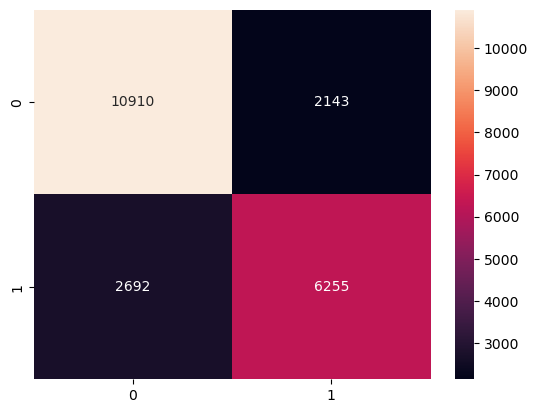

In [24]:
#Create Confussion Matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82     13053
         1.0       0.74      0.70      0.72      8947

    accuracy                           0.78     22000
   macro avg       0.77      0.77      0.77     22000
weighted avg       0.78      0.78      0.78     22000



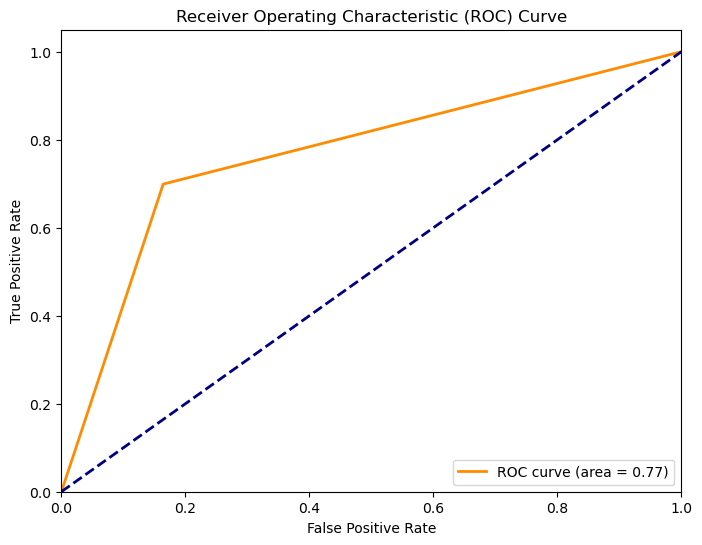

In [26]:
from sklearn.metrics import roc_curve, auc
# y_test and y_pred are the true labels and predicted labels, respectively
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()